To: My Springboard Mentor
From: Scott Hensley

As we begin getting into the heart of the Capstone, I'd like to start with a general overview of where this is heading, partly because it keeps me organized, and partly so domain knowledge is explained. These Capstones are heading in the direction of Bayesian Inference where "prior probabilities" will need to be established which is dependant upon said domain knowledge.

I don't believe GitHub is going to allow me to upload this amount of data; therefore, we will be relying on these notebooks as well as these descriptions on how the things are structured as I always initialize my programs in Pycharm due its ease in not only seeing the dataframes in a horizontal formats that allows for easier  analysis, but also because I will always try to rely on a large dose of source Python programming to keep those skills sharp and Pycharm's debugging and live coding are superior.

General Overview:

I know I've listed these general overviews in previous assignments, but it's cumbersome to review those, and more importantly, the plan is changing as things develop over time, and that is the case since I turned in the data wrangling file.

- There are 6 separate .edf files read in through mne-python that reduces them to large numpy arrays that are the put into a pandas dataframe.

- Each data point in the dataframe represents an electrical reading measured in Amperes. These units are consistent throughout all files. I will normalize these in the modeling stage, but not in the EDA stage. The range of values can be large and their domain is the positive and negative Real number system.

- Normalization will occur in modeling in reduce the vast amount of noise in the data resulting from motor skill activity, although the experimenters that captured the attempted to control for that, so the data is less noisy than would normally be the case.

- These 6 .edf files will ultimately be reduced to 3 larger files, each of which are ~2 hours worth of EEG readings, and each of those are ~ an hour and a half long. The time is broken down into 256 readings per second which resulted in row counts in the tens of millions. For programming ease, these time are converted to a zero-based integer index.

- Each of these 3 files end in a recorded seizure. Therefore, each file can be separated into 2 separate dataframes:
	1. The "X" set contains the massive amount of data leading up to the seizure, but does not contain it.
	2. The "y" set contains only the seizure.

- These "X" and "y" sets will become the training and test sets for the modeling stage.

- The "X" and "y" variable names will also contain other information in them so keeping track of what's going on will be easier.

- There are 2 patients.

- Patient 1 is always identified through the Capstone by the number 1 somewhere in the variable, dictionary key, or a  dataset. Therefore, patient will 2 will always have a 2 somewhere in the name.

- Patient 1 has an intial EEG and then another recorded 18 months later.

- Patient 2 only has one EEG recording, but it's unique in that this patient has a VNS device surgically inserted in an attempt to control seizures.

The Plan:

It's important to understand that I couldn't come up with a plan to split a single "X" and "y" into training and testing sets that I felt preserved integrity because it's a chronological time series. Each row is not a unique instance represented by the features.

But it turns out an elegant solution to this issue already existed due to the nature of the chosen data sets.

* Patient 1's intial "X" and "y" set will be used to train the model.
* Patient 1's second "X" and "y" set will be used to test the model.
* Patient 2's VNS set will be used to test the model.

More specifically,
	X_patient_1 = the X_train (a huge dataset guaranteed to NOT have a seizure) is a baseline EEG for the patient.
	y_patient_1 = the y_train (the seizure data set that resulted at the end X_patient_1)

In a flow of time moving forward::

time  ->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->

X_train:    ->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->   y-train

baseline EEG -> (threshold to) -> pre-aura EEG if it exists -> (threshold to) -> aura EEG if it exists -> (threshold)  ->  seizure definitely exists

The alternate hypothesis is then:
	There are electrical patterns identifying pre-auras in the X_train that lead to auras (if the exists) that lead the seizure.
	Each of each of these thresholds could be seen as increased electrical energy or a change in baseline patterns across the features at a point in time.

The null hypothesis is then
	The seizures are NOT caused by any of the data leading up to the seizure and occur randomly as if from nothing.

This null would mean the seizure source is in the neurons electrical output and/or their inability to act as a surge protector to the rest of the brain.

This model will then be tested on the same patient 187 months later. WIll it recognize the patients "baseline EEG" and predict the seizure that is definitely coming.

The model will then be tested on the VNS patient, who has a different "baseline" than the one on which the model was trained

In [239]:
"""functions designed to be called when an .edf file needs to be cleaned and organized """

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import warnings  # Hide all warnings here
from pandas_profiling import ProfileReport

mne.set_log_level('WARNING')
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

master_data_patient_dict = {}

added_columns = ['seizure = 1','outer_left_hemi_sum','inner_left_hemi_sum','outter_right_hemi_sum',
                 'inner_right_hemi_sum','center_line','left_temple_to_left_rear','temple_to_temple',
                 'right_temple_to_right_rear']


def load_pandas_data(filename):
	""" converts raw data from an .edf file to a dataframe"""

	mne.set_log_level('WARNING')
	warnings.simplefilter("ignore")

	patient = mne.io.read_raw(filename,preload=True)
	return patient.to_data_frame()


def prepare_df_for_analysis(preseizure_set,seizure_set,start,end):
	"""

	Prepares a master dataframe for the analysis.
	:param preseizure_set: a full EEG set without a seizure
	:param seizure_set: an EEG with a seizure and then truncated after the seizure
	to reduce file size
	:param start: start time of the seizure as listed in the summary file from Children's hospital data set
	:param end: end time of the seizure as listed in the summary file from Children's hospital data set
	:return: a dataframe

	"""

	preseizure_set.set_index('time',inplace=True)
	seizure_set.set_index('time',inplace=True)

	preseizure_set['seizure = 1'] = 0
	seizure_set['seizure = 1'] = 0

	seizure_set.loc[start: end,'seizure = 1'] = 1

	patient = pd.concat([preseizure_set,seizure_set],axis=0,ignore_index=True)

	# left hemisphere location totals
	patient['outer_left_hemi_sum'] = patient[['FP1-F7','F7-T7','T7-P7','P7-O1']].sum(axis=1)
	patient['inner_left_hemi_sum'] = patient[['FP1-F3','F3-C3','C3-P3','P3-O1']].sum(axis=1)

	# right hemisphere location totals
	patient['outter_right_hemi_sum'] = patient[['FP2-F8','F8-T8','T8-P8-0','P8-O2']].sum(axis=1)
	patient['inner_right_hemi_sum'] = patient[['FP2-F4','F4-C4','C4-P4','P4-O2']].sum(axis=1)

	# center totals
	patient['center_line'] = patient[['FZ-CZ','CZ-PZ']].sum(axis=1)

	# left temple to rear totals
	patient['left_temple_to_left_rear'] = patient[['FZ-CZ','CZ-PZ']].sum(axis=1)

	# temple to temple totals
	patient['temple_to_temple'] = patient[['FT9-FT10']].sum(axis=1)

	# left temple to rear totals
	patient['right_temple_to_right_rear'] = patient[['FT10-T8','T8-P8-1']].sum(axis=1)

	# reorder columns for better visual early analysis
	new_cols = ['seizure = 1',
	            'FP1-F7','F7-T7','T7-P7','P7-O1','outer_left_hemi_sum',
	            'FP1-F3','F3-C3','C3-P3','P3-O1','inner_left_hemi_sum',
	            'FP2-F8','F8-T8','T8-P8-0','P8-O2','outter_right_hemi_sum',
	            'FP2-F4','F4-C4','C4-P4','P4-O2','inner_right_hemi_sum',
	            'FZ-CZ','CZ-PZ','center_line',
	            'P7-T7','T7-FT9','left_temple_to_left_rear',
	            'FT9-FT10','temple_to_temple',
	            'FT10-T8','T8-P8-1','right_temple_to_right_rear']

	patient = patient.reindex(columns=new_cols)
	patient.set_index(create_int_index(patient),inplace=True)

	locations = seizure_location(patient)
	patient = patient.iloc[: locations[1] + 1,:]

	return patient


def is_df_clean(df):
	""" Check if a dataframe is clean. """
	for i in range(df.count().all().tolist()):
		if not i:
			return f"There are null values in {df.columns[i]}: " \
				   f"Note: this is expected if column is 'seizures = 1' as most of the values are zero, but 1 where the seizure exist."
	for j in np.isinf(df).sum().any().to_list():
		if not j:
			return f'There are infinite values in {df.columns[j]}'


def create_int_index(df):
	"""Create and return an index that is `int` based"""
	return np.linspace(0,len(df),len(df),dtype=int)


def seizure_location(df):
	"""Return the index locations of the seizure."""

	seizure_location = df.index[df['seizure = 1'] != 0].tolist()
	# seizure_start, seizure_end = seizure_location[0], seizure_location[-1]

	return seizure_location[0],seizure_location[-1]


def make_needed_dataframe(master_df, columns: list, patient: str,master_dict) -> dict:
	# sourcery skip: dict-literal, merge-dict-assign
	"""
    Make a variety of  X, y training and test sets for a variety of EDA and modeling needs.
    """

	local_patient_dict = dict()

	# have a master with seizure column but NOT seizure columns
	local_patient_dict['all data minus seizure column'] = master_df.drop(columns[0],axis=1,inplace=False)

	# have a master without any added columns
	local_patient_dict['all data minus added columns'] = master_df.drop(columns,axis=1,inplace=False)

	# have a master with only summary columns
	local_patient_dict['X only summary columns'] = master_df[columns[1:]]

	# create the Xs
	local_patient_dict['X all columns'] = master_df[master_df['seizure = 1'] != 1]
	local_patient_dict['X no added columns'] = local_patient_dict['X all columns'].drop(columns,axis=1,
	                                                                                  inplace=False)
	local_patient_dict['X only summary columns'] = local_patient_dict['X all columns'][columns[1:]]

	# create the ys
	local_patient_dict['y all columns'] = master_df[master_df['seizure = 1'] != 0]
	local_patient_dict['y no added column'] = local_patient_dict['y all columns'].drop(columns,axis=1,
	                                                                                   inplace=False)
	local_patient_dict['y only summary columns'] = local_patient_dict['y all columns'][columns[1:]]

	master_dict[patient] = local_patient_dict

	return master_dict


In [240]:
# identify the raw .edf files

raw_p1_02_nonseizure = '/Users/jshensley/Desktop/springboard/DS_Method_and_Capstones/capstone_2_2/capstone_2/a_cookiecutter_for_capstone_2/{{ cookiecutter.seizure_prediction_model }}/notebooks/Capstone2_dataset/patient_1/intial_EEG/chb01_02_nonseizure_set_just_before_seizure_set.edf'

raw_p1_02_seizure_set = '/Users/jshensley/Desktop/springboard/DS_Method_and_Capstones/capstone_2_2/capstone_2/a_cookiecutter_for_capstone_2/{{ cookiecutter.seizure_prediction_model }}/notebooks/Capstone2_dataset/patient_1/intial_EEG/chb01_02_nonseizure_set_just_before_seizure_set.edf'

In [241]:
# load the .edf files and convert the underlying numpy arrays to a dataframe
p1_preseizure = load_pandas_data(raw_p1_02_nonseizure)
p1_seizure = load_pandas_data(raw_p1_02_seizure_set)

# run through a sequence of dataframe preprocessing for later modeling
p1_datasets = make_needed_dataframe(
		master_df=prepare_df_for_analysis(
				preseizure_set=p1_preseizure,
				seizure_set=p1_seizure,
				start=2996,
				end=3036),
		columns=added_columns,
		patient='Patient 1 initial set',
		master_dict=master_data_patient_dict)

How are the datasets stored? What are they called?

In [242]:
available_datasets = master_data_patient_dict['Patient 1 initial set']
for k in available_datasets.keys():
	print(f'"{k}"\n')

"all data minus seizure column"

"all data minus added columns"

"X only summary columns"

"X all columns"

"X no added columns"

"y all columns"

"y no added column"

"y only summary columns"



We'll start with basic descriptions of the X and Y datasets then move to the X an y summary datasets'

In [243]:
X_train_describe = master_data_patient_dict['Patient 1 initial set']['X no added columns'].describe().transpose()
X_train_describe

,count,mean,std,min,25%,50%,75%,max
FP1-F7,1688576.0,0.230753,54.740631,-580.415140,-18.559219,-0.586081,16.605617,779.291819
F7-T7,1688576.0,0.204007,31.635561,-436.239316,-13.089133,0.195360,13.089133,554.236874
T7-P7,1688576.0,0.188780,24.839441,-453.431013,-12.698413,0.195360,13.089133,390.525031
P7-O1,1688576.0,0.236891,21.224226,-304.957265,-11.526252,0.195360,11.916972,221.343101
FP1-F3,1688576.0,0.225937,52.827309,-619.096459,-21.294261,-0.586081,18.949939,674.578755
F3-C3,1688576.0,0.148782,26.156212,-279.560440,-14.652015,0.195360,15.433455,251.819292
C3-P3,1688576.0,0.211710,18.239619,-224.468864,-10.744811,0.195360,11.135531,208.840049
P3-O1,1688576.0,0.265594,24.151397,-245.177045,-14.652015,-0.195360,14.261294,233.064713
FP2-F8,1688576.0,0.222413,44.050657,-555.409035,-16.996337,-0.195360,15.824176,608.156288
F8-T8,1688576.0,0.207983,32.992028,-412.405372,-15.824176,-0.586081,15.042735,383.882784


In [244]:
y_train_describe = master_data_patient_dict['Patient 1 initial set']['y no added column'].describe().transpose()

Put descriptions together and sort for easier comparison

In [245]:
trains_compared = pd.concat([X_train_describe, y_train_describe], axis=1)
trains_compared.columns =['countx','meanx','stdx','minx','25%x','50%x','75%x','maxx','county','meany','stdy','miny','25%y','50%y','75%y',
'maxy']
trains_compared.sort_index(axis=1)

,25%x,25%y,50%x,50%y,75%x,75%y,countx,county,maxx,maxy,meanx,meany,minx,miny,stdx,stdy
FP1-F7,-18.559219,-11.135531,-0.586081,0.195360,16.605617,11.916972,1688576.0,10241.0,779.291819,135.775336,0.230753,0.162015,-580.415140,-204.542125,54.740631,26.069786
F7-T7,-13.089133,-10.354090,0.195360,0.586081,13.089133,11.526252,1688576.0,10241.0,554.236874,91.623932,0.204007,0.078003,-436.239316,-116.239316,31.635561,21.236988
T7-P7,-12.698413,-10.744811,0.195360,0.195360,13.089133,11.916972,1688576.0,10241.0,390.525031,81.855922,0.188780,0.312412,-453.431013,-96.703297,24.839441,19.825202
P7-O1,-11.526252,-11.526252,0.195360,0.195360,11.916972,12.307692,1688576.0,10241.0,221.343101,98.656899,0.236891,0.374677,-304.957265,-76.385836,21.224226,20.283379
FP1-F3,-21.294261,-14.652015,-0.586081,0.195360,18.949939,16.605617,1688576.0,10241.0,674.578755,137.338217,0.225937,0.303141,-619.096459,-133.821734,52.827309,31.127361
F3-C3,-14.652015,-15.042735,0.195360,0.586081,15.433455,15.042735,1688576.0,10241.0,251.819292,201.025641,0.148782,-0.049350,-279.560440,-183.052503,26.156212,31.956879
C3-P3,-10.744811,-10.744811,0.195360,0.195360,11.135531,11.526252,1688576.0,10241.0,208.840049,83.418803,0.211710,0.307338,-224.468864,-87.716728,18.239619,18.688414
P3-O1,-14.652015,-14.261294,-0.195360,-0.195360,14.261294,15.042735,1688576.0,10241.0,233.064713,120.537241,0.265594,0.382041,-245.177045,-99.438339,24.151397,24.295570
FP2-F8,-16.996337,-12.698413,-0.195360,0.195360,15.824176,13.479853,1688576.0,10241.0,608.156288,126.788767,0.222413,0.104557,-555.409035,-162.344322,44.050657,26.606800
F8-T8,-15.824176,-13.870574,-0.586081,0.195360,15.042735,14.261294,1688576.0,10241.0,383.882784,130.695971,0.207983,0.037447,-412.405372,-134.603175,32.992028,26.137961


I feel correlation will not be a factor in this analysis.

Why?

Because each lead will be picking up energy waves from surrounding leads, saturating everything around it, at minimum the hemisphere. There are connections between the hemispheres, notably the Corpus Colossum, and if that has not been severed by neurosurgeons, then electrical energy from all areas of the brain could be registered by all EEG leads…..otherwise known as noise.

In other words, because the brain acts non-linearly across the entire organ, the brain would self-correlate.

This may have been a primary reason for taking differences of leads, the sign in from of the difference will show from which direction the energy came.
For example:

<AxesSubplot:xlabel='stdx', ylabel='stdy'>

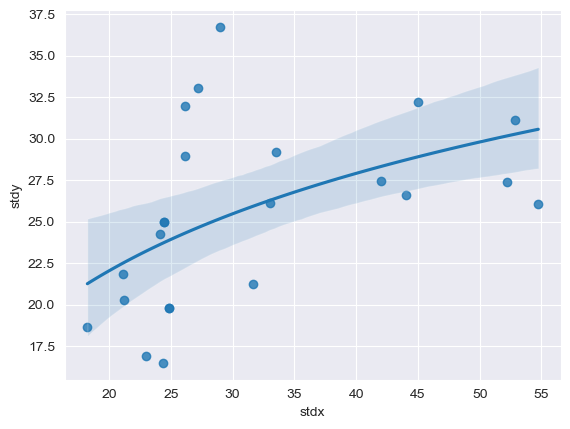

In [246]:
def sns_line(data, x , y, fit_reg=True, n_boot=2000, seed=911, logx=True, truncate=True):
	return sns.regplot(data=trains_compared, x='stdx', y='stdy', fit_reg=True, n_boot=2000, seed=911, logx=True, truncate=True)

sns_line(data=trains_compared, x='stdx', y='stdy')

<AxesSubplot:xlabel='stdx', ylabel='stdy'>

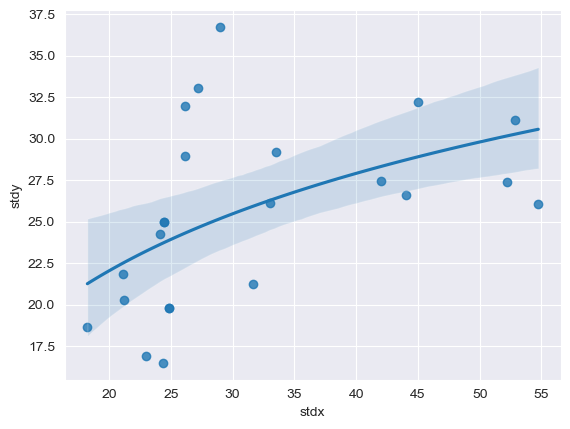

In [247]:
sns_line(data=trains_compared, x='meanx', y='meany')

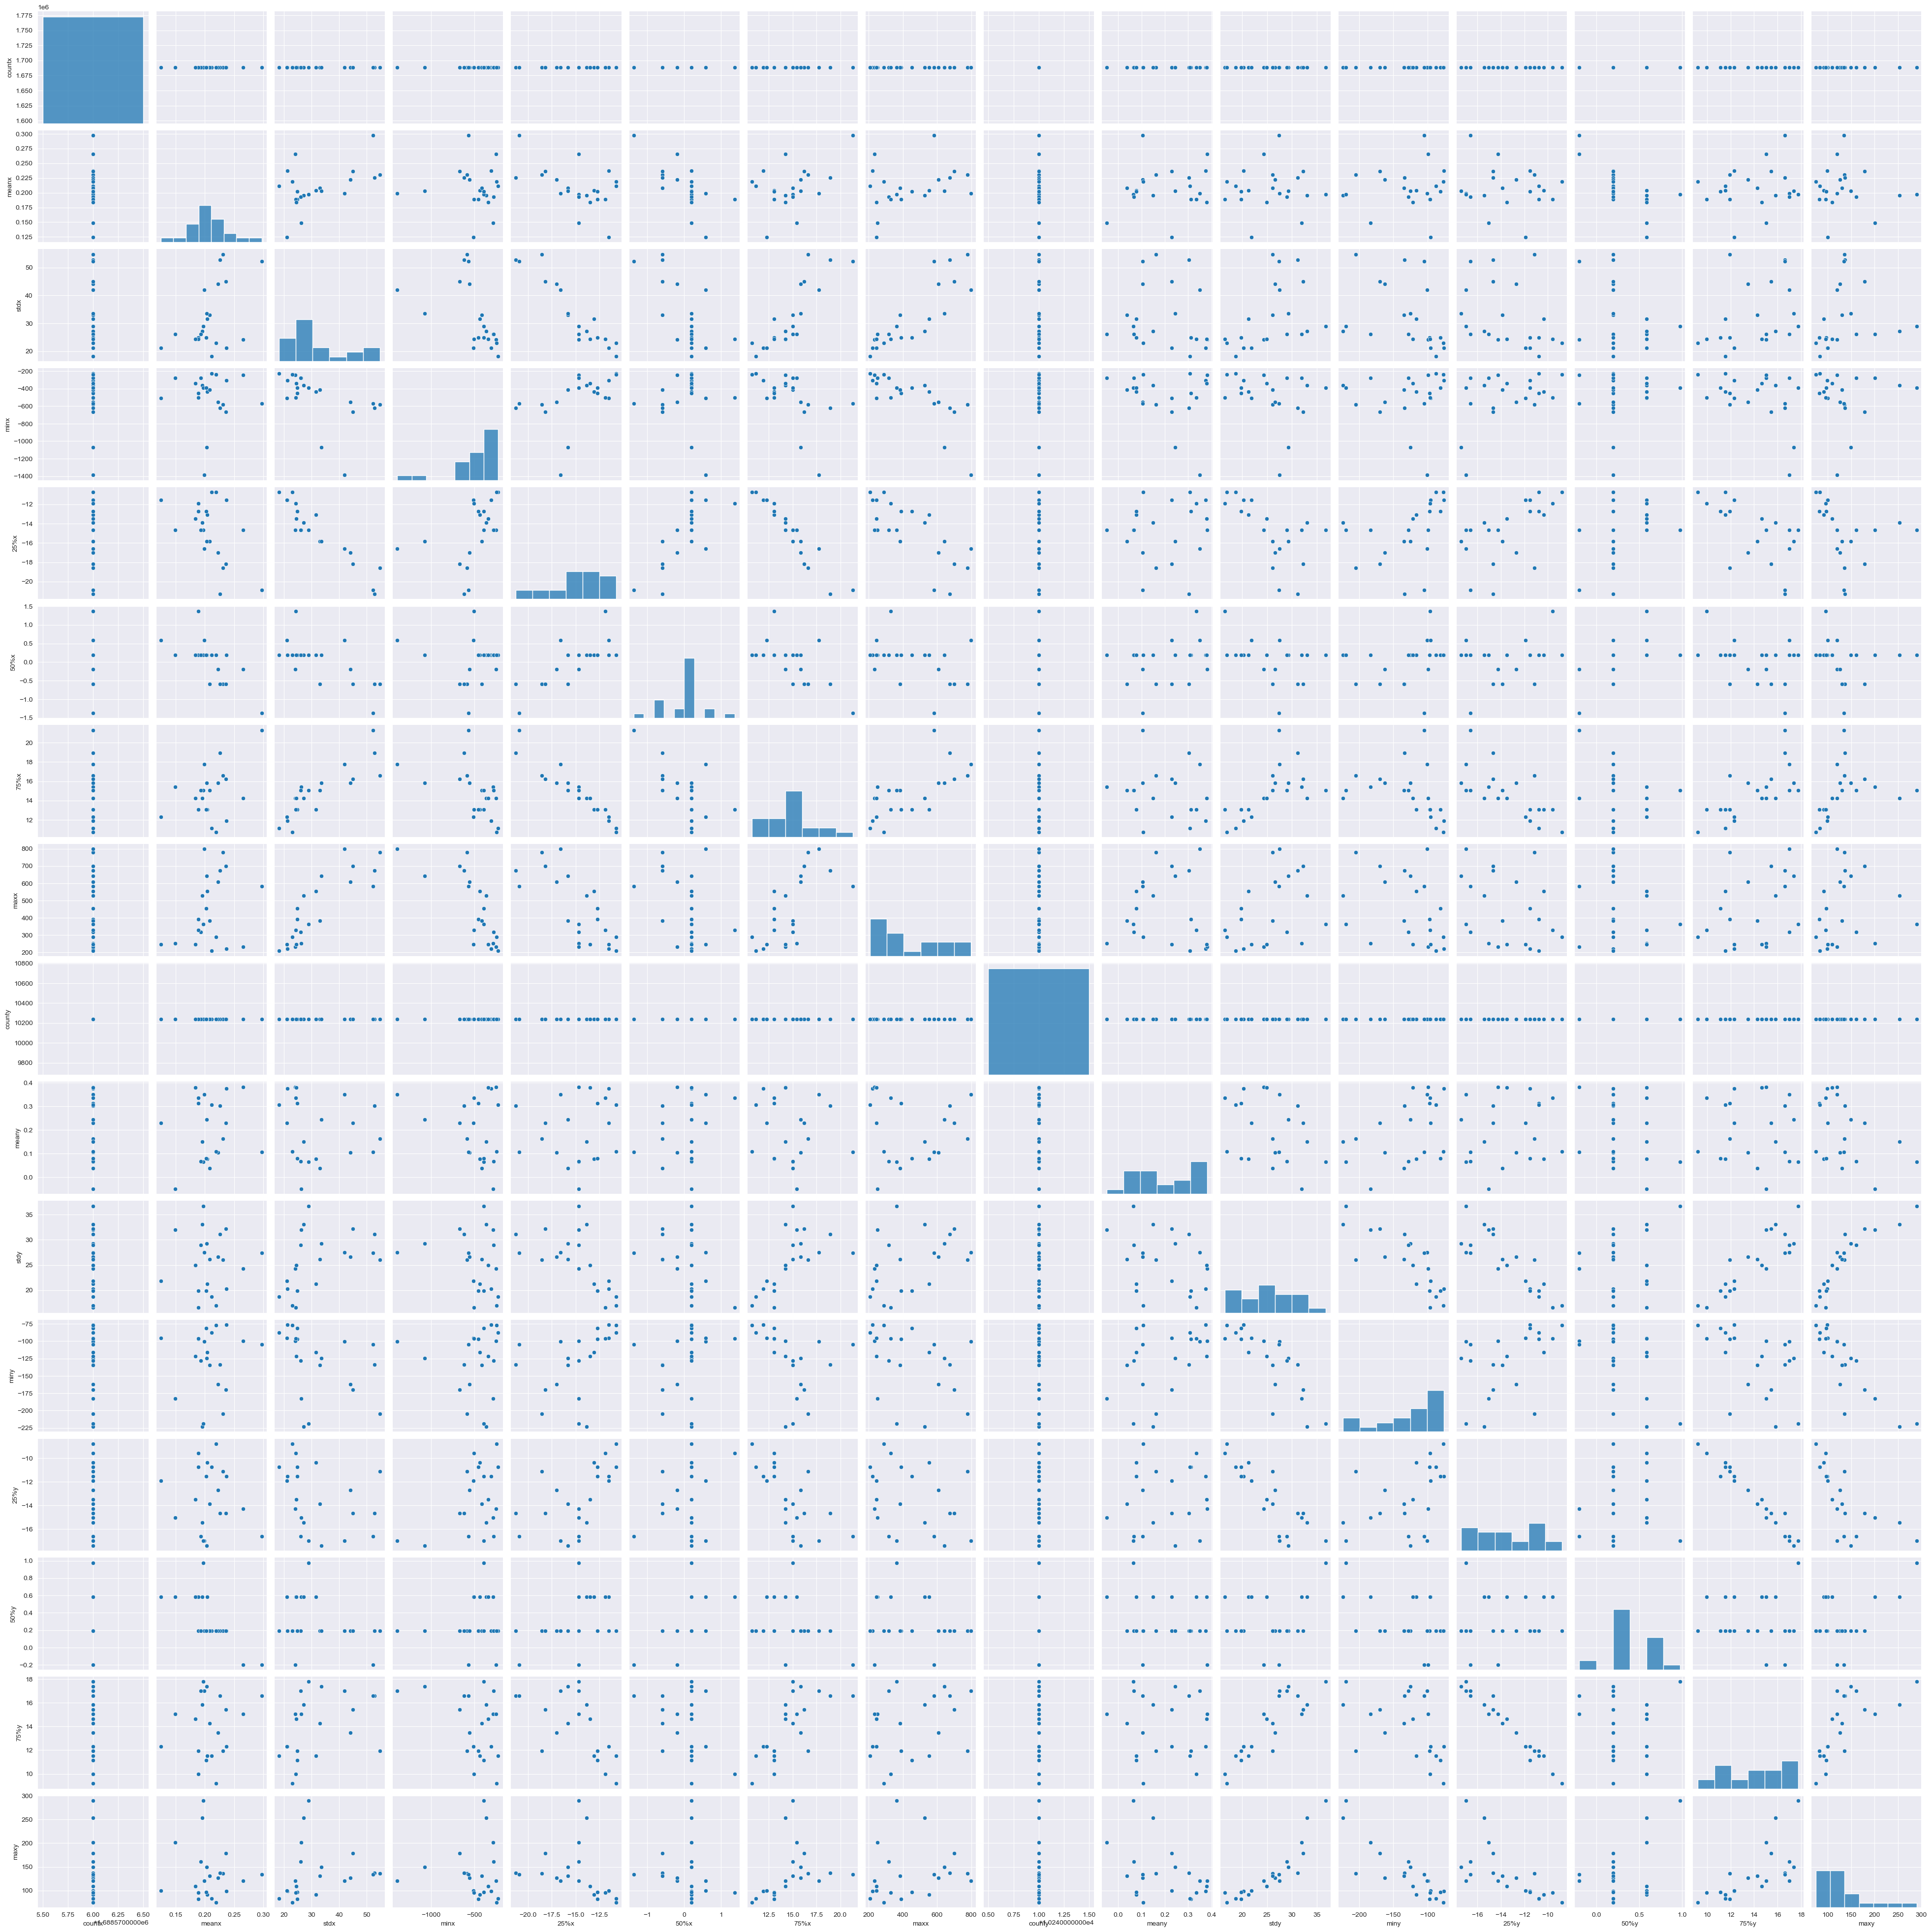

In [248]:
sns.pairplot(data=trains_compared)

In [250]:
X_summary_describe = master_data_patient_dict['Patient 1 initial set']['X only summary columns'].describe().transpose()
X_summary_describe

,count,mean,std,min,25%,50%,75%,max
outer_left_hemi_sum,1688576.0,0.860431,72.821711,-544.664225,-31.648352,3.552714e-15,31.257631,822.075702
inner_left_hemi_sum,1688576.0,0.852023,72.763874,-545.054945,-31.648352,1.776357e-15,31.257631,820.122100
outter_right_hemi_sum,1688576.0,0.812696,73.157846,-1220.610501,-32.429792,3.907204e-01,32.429792,963.125763
inner_right_hemi_sum,1688576.0,0.759570,72.805588,-1215.921856,-32.039072,3.907204e-01,32.039072,961.172161
center_line,1688576.0,0.389912,39.011903,-497.777778,-21.489621,3.907204e-01,22.271062,333.284493
left_temple_to_left_rear,1688576.0,0.389912,39.011903,-497.777778,-21.489621,3.907204e-01,22.271062,333.284493
temple_to_temple,1688576.0,0.297334,52.193334,-568.302808,-20.903541,-1.367521e+00,21.294261,583.540904
right_temple_to_right_rear,1688576.0,0.403070,37.400761,-358.290598,-19.145299,3.907204e-01,19.536020,393.846154


In [251]:
y_summary_describe = master_data_patient_dict['Patient 1 initial set']['y only summary columns'].describe().transpose()

In [252]:
trains_sums_compared = pd.concat([X_summary_describe, y_summary_describe], axis=1)
trains_sums_compared.columns =['countx','meanx','stdx','minx','25%x','50%x','75%x','maxx','county','meany','stdy','miny','25%y','50%y','75%y',
'maxy']
trains_sums_compared.sort_index(axis=1)

,25%x,25%y,50%x,50%y,75%x,75%y,countx,county,maxx,maxy,meanx,meany,minx,miny,stdx,stdy
outer_left_hemi_sum,-31.648352,-27.741148,3.552714e-15,1.562882,31.257631,30.085470,1688576.0,10241.0,822.075702,313.357753,0.860431,0.927107,-544.664225,-311.013431,72.821711,55.564994
inner_left_hemi_sum,-31.648352,-28.131868,1.776357e-15,1.562882,31.257631,30.085470,1688576.0,10241.0,820.122100,313.748474,0.852023,0.943169,-545.054945,-310.231990,72.763874,55.752882
outter_right_hemi_sum,-32.429792,-28.913309,3.907204e-01,1.562882,32.429792,31.257631,1688576.0,10241.0,963.125763,287.570208,0.812696,0.871443,-1220.610501,-330.940171,73.157846,58.344199
inner_right_hemi_sum,-32.039072,-28.913309,3.907204e-01,1.953602,32.039072,30.866911,1688576.0,10241.0,961.172161,287.960928,0.759570,0.852977,-1215.921856,-330.940171,72.805588,58.217236
center_line,-21.489621,-25.006105,3.907204e-01,1.172161,22.271062,25.006105,1688576.0,10241.0,333.284493,311.404151,0.389912,0.131779,-497.777778,-289.523810,39.011903,49.463665
left_temple_to_left_rear,-21.489621,-25.006105,3.907204e-01,1.172161,22.271062,25.006105,1688576.0,10241.0,333.284493,311.404151,0.389912,0.131779,-497.777778,-289.523810,39.011903,49.463665
temple_to_temple,-20.903541,-16.605617,-1.367521e+00,-0.195360,21.294261,16.605617,1688576.0,10241.0,583.540904,134.212454,0.297334,0.105625,-568.302808,-104.908425,52.193334,27.428797
right_temple_to_right_rear,-19.145299,-18.363858,3.907204e-01,0.781441,19.536020,20.317460,1688576.0,10241.0,393.846154,157.460317,0.403070,0.488086,-358.290598,-186.373626,37.400761,34.434195


<AxesSubplot:xlabel='stdx', ylabel='stdy'>

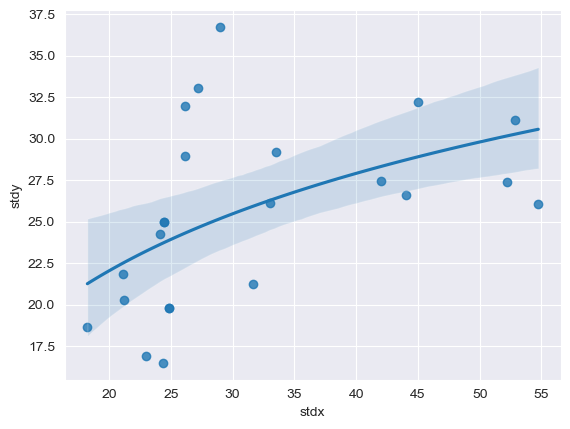

In [253]:
sns_line(data=y_summary_describe, x='stdx', y='stdy')

<AxesSubplot:xlabel='stdx', ylabel='stdy'>

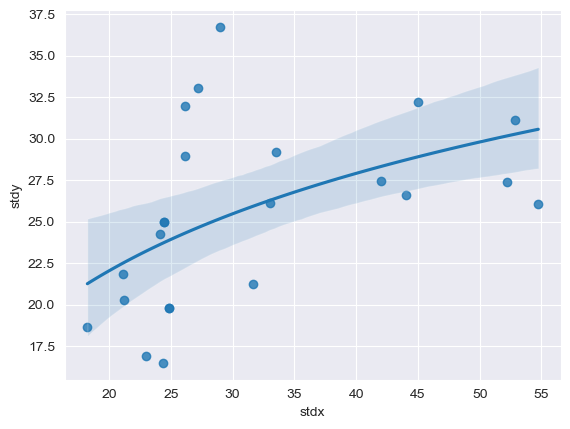

In [254]:
sns_line(data=y_summary_describe, x='stdx', y='stdy')

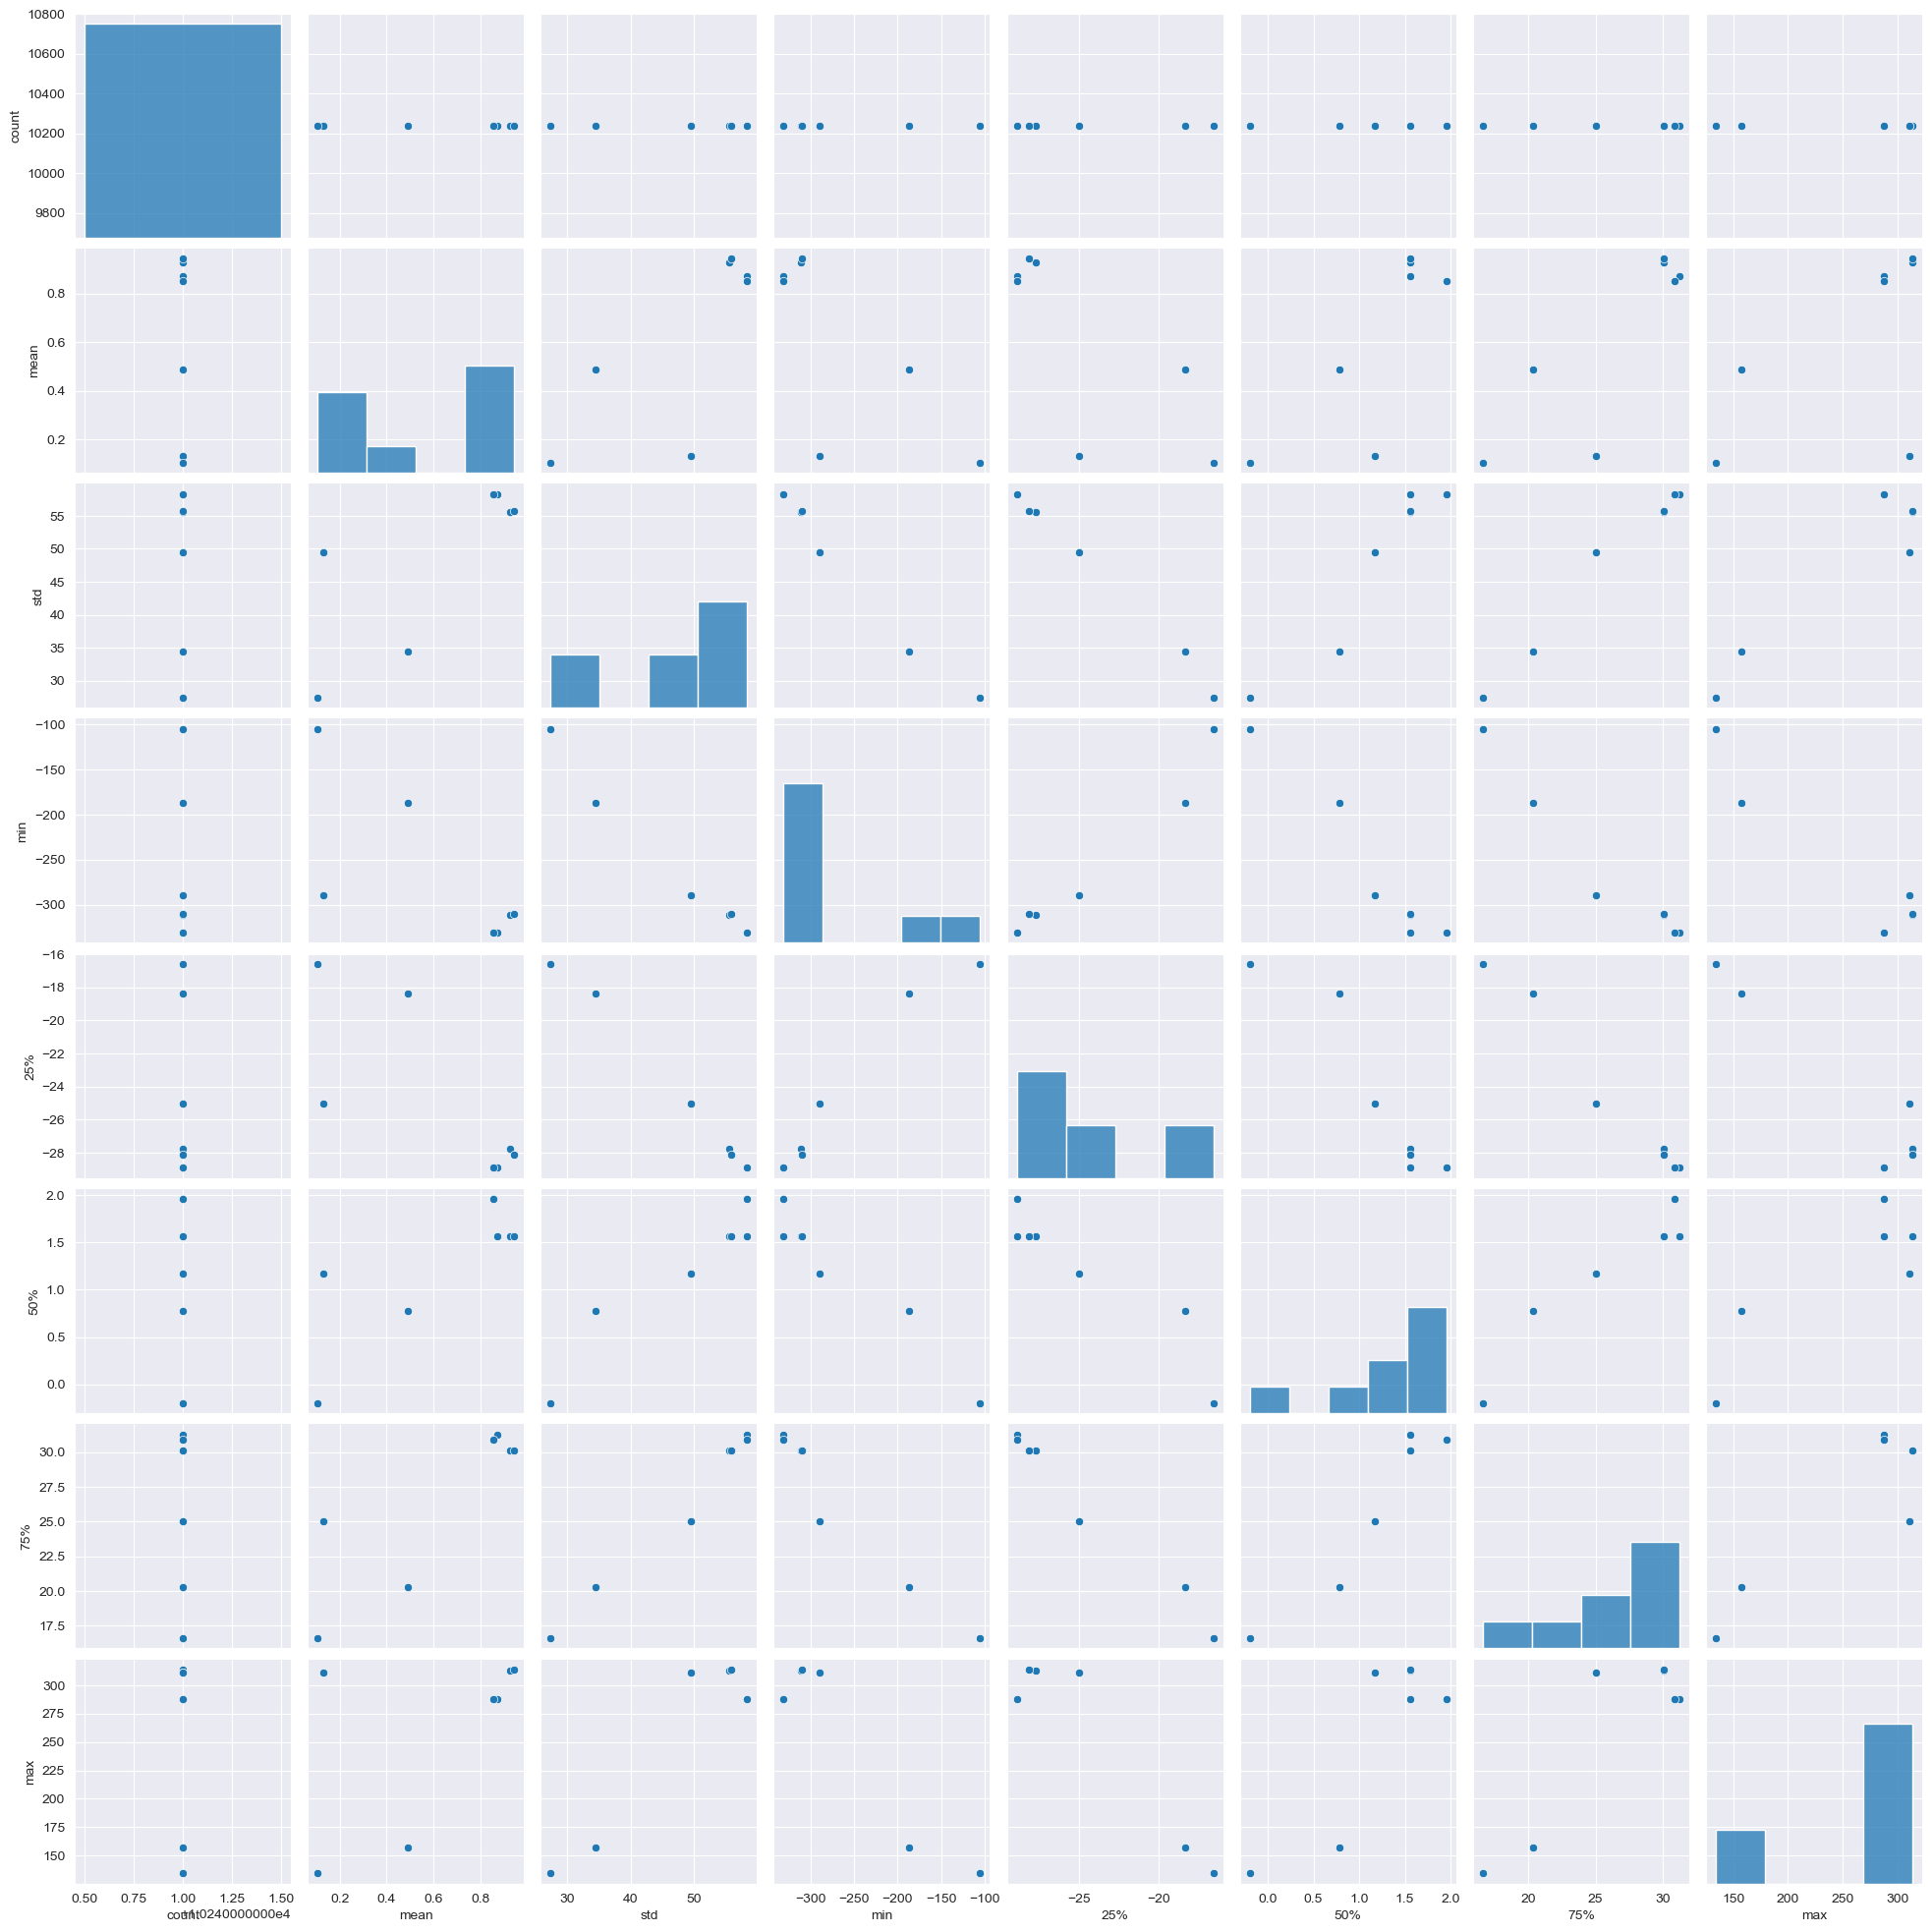

In [255]:
sns.pairplot(data=y_summary_describe)

Split x into sets and analyze summary stats to see if there is a general trend?

An important concept to understand in EEG measurements is that no single EEG lead's measurement is significant, rather  the differences between two of the leads is what counts.

For example: T7 - P7 (the last histogram above) is exactly what it says:

T7's electrical measurement MINUS  P7's electrical measurement = the data point.

The consequence of this is that we can track which leads are "tied" together (they are not linked.

For example: the first four features are:

'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1'
Note the intersection of any two consecutive leads exists, ie: F7 is the intersection of the first leads

These "linked" EEG leads identify a particular section of the brain.
In this example, 'FP1-F7', 'F7-T7', 'T7-P7', and 'P7-O1' identify the the left_outter side of the head.

A natural thing to wonder is what would the sum of these say?

The code variable, added_columns, is just that.
added_columns is the set of the engineered features to show the summations of these linked leads that identify the sections of the brain.

In [ ]:
master_data_patient_dict['Patient 1 initial set']['X all columns'].head(1).drop('seizure = 1', axis=1)


Feature 1's  FP1-F7 is positive: so the stronger signal was in the forward area of the frontal lobe and was moving toward the rear.
Then F7-T7 was again positive: the strongest waves are still moving front to back.
Next, T7-P7 is not only positive, but larger, indicating not only is the wave moving front to back, but also picked up additional energy from somewhere.
And it appears that the somewhere is from the next lead, O1 whose value is negative, indicating the energy is traveling back to front, and the collision amounted to the larger number.

The total for the "outer_left_hemi_sum" is ~44, indicating the general path was front to back.

Of course this assists nuerologist in identifying from where a seizure starts.

Maybe this knowledge will assist in establishing the "prior" in Bayes Theorem later on.